# Устанавливаю зависимости

In [2]:
version
# Устанавливаю рабочим катологом корень проекта, а не папку notebooks
setwd("/mnt/e/Projects/03_Education/PlacentaCancer")
getwd()

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          4.2                         
year           2024                        
month          10                          
day            31                          
svn rev        87279                       
language       R                           
version.string R version 4.4.2 (2024-10-31)
nickname       Pile of Leaves              

[1] "/mnt/e/Projects/03_Education/PlacentaCancer"

In [64]:
library(tximport)
library(ggplot2)
library(ggrepel)
library(MASS)
library(stringr)
library(readr)
library(DESeq2)
library(apeglm)

# tximport 

Использую `tximport` для агрегации данных с уровня транскриптов до уровня генов

Воспользуюсь готовым `transcript-to-gene` файлом из сборки индексов для kallisto, загруженной ранее

In [27]:
t2g <- read.table(
    file = "./human_index_standard/t2g.txt",
    header=FALSE,
    col.names = c("t_id", "g_id", "g_name", "t_name", "chr", "start", "end", "strand"),
    sep="\t"
    )

In [28]:
samples_info <- read_csv(
    "data/SraRunTable.csv",
    col_types = c()
)
samples_info$treatment <- as.factor(samples_info$sex)
samples_info = samples_info[,c("Run", "sex")]
samples_info

Rows: 12 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (29): Run, Assay Type, BioProject, BioSample, cell_line, cell_type, Cen...
dbl   (4): AvgSpotLen, Bases, Bytes, version
dttm  (2): ReleaseDate, create_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Run,sex
<chr>,<chr>
SRR32130961,male
SRR32130962,male
SRR32130963,male
SRR32130964,male
SRR32130965,male
SRR32130966,male
SRR32130973,female
SRR32130974,female
SRR32130975,female


In [29]:
samples_files = str_c(samples_info$Run,"_abundance.tsv")
samples_files = file.path(getwd(),"data","quant", samples_files)
names(samples_files) <- paste(samples_info$sex, 1:6, sep="_")

In [30]:
txi <- tximport(
    samples_files,
    type="kallisto",
    tx2gene=t2g,
    ignoreAfterBar=TRUE
)

Note: importing `abundance.h5` is typically faster than `abundance.tsv`



reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


summarizing abundance

summarizing counts

summarizing length



In [31]:
ddsTxi <- DESeqDataSetFromTximport(
    txi, 
    colData = samples_info[,c('sex')], 
    design = ~ sex
)
ddsTxi

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



class: DESeqDataSet 
dim: 39546 12 
metadata(1): version
assays(2): counts avgTxLength
rownames(39546): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000291300.1 ENSG00000291301.1
rowData names(0):
colnames(12): male_1 male_2 ... female_5 female_6
colData names(1): sex

Добавлю стандартные название генов, NCBI ID, и gene-type

In [32]:
require(org.Hs.eg.db)
Symbol <- mapIds(
    org.Hs.eg.db,
    keys=gsub("\\.\\d+$", "", rownames(ddsTxi)),
    keytype="ENSEMBL",
    column="SYMBOL"
)

Entrez <- mapIds(
    org.Hs.eg.db,
    keys=gsub("\\.\\d+$", "", rownames(ddsTxi)),
    keytype="ENSEMBL",
    column="ENTREZID"
)

Genetype <- mapIds(
    org.Hs.eg.db,
    keys=gsub("\\.\\d+$", "", rownames(ddsTxi)),
    keytype="ENSEMBL",
    column="GENETYPE"
)

genesMetaData <- data.frame(
    Symbol=Symbol,
    Entrez=Entrez,
    Genetype=Genetype
)
rowData(ddsTxi) <- genesMetaData

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi




Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:MASS’:

    select




'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [33]:
head(rowData(ddsTxi))

DataFrame with 6 rows and 3 columns
                        Symbol      Entrez       Genetype
                   <character> <character>    <character>
ENSG00000000003.15      TSPAN6        7105 protein-coding
ENSG00000000005.6         TNMD       64102 protein-coding
ENSG00000000419.14        DPM1        8813 protein-coding
ENSG00000000457.14       SCYL3       57147 protein-coding
ENSG00000000460.17       FIRRM       55732 protein-coding
ENSG00000000938.13         FGR        2268 protein-coding

Отфильтрую только `protein-coding`

In [36]:
keep <- rowData(ddsTxi)$Genetype == "protein-coding"
keep[is.na(keep)] <- FALSE
ddsTxi <- ddsTxi[keep,]

Отфильтрую низкоэкспрессированные гены. Оставлю, если есть более 5 каунтов хотя бы в 2 образцах.

In [37]:
smallestGroupSize <- 2
keep <- rowSums(counts(ddsTxi) >= 5) >= smallestGroupSize
ddsTxi <- ddsTxi[keep,]

## Результаты

провожу оценку диф эксрессии методом Wald-test

In [38]:
dds <- DESeq(ddsTxi)
resultsNames(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"          "sex_male_vs_female"

In [39]:
res <- results(dds, name="sex_male_vs_female")
rownames(res) <- 
summary(res)
as.data.frame(head(res))


out of 14357 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 853, 5.9%
LFC < 0 (down)     : 879, 6.1%
outliers [1]       : 3, 0.021%
low counts [2]     : 557, 3.9%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.15,713.30069,-0.28798582,0.1698390,-1.6956404,0.089954002,0.31791500
ENSG00000000419.14,1230.22580,-0.60210333,0.2230782,-2.6990689,0.006953378,0.06901853
ENSG00000000457.14,168.58461,-0.10233806,0.1962922,-0.5213558,0.602118909,0.81312097
ENSG00000000460.17,478.39565,0.07532191,0.2197440,0.3427711,0.731770655,0.88253844
ENSG00000000938.13,16.83439,-2.08556933,0.7118297,-2.9298713,0.003391024,0.04386312
ENSG00000001036.14,3618.91304,-0.18314867,0.1599773,-1.1448417,0.252274751,0.54410423


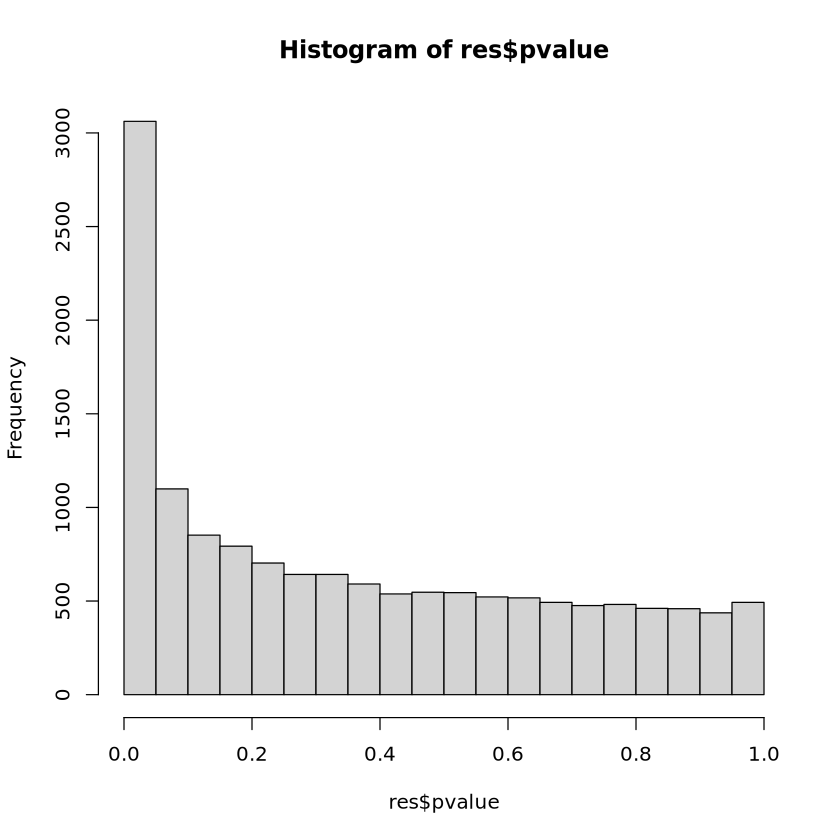

In [40]:
hist(res$pvalue)

Warning message:
“Removed 560 rows containing missing values or values outside the scale range
(`geom_point()`).”


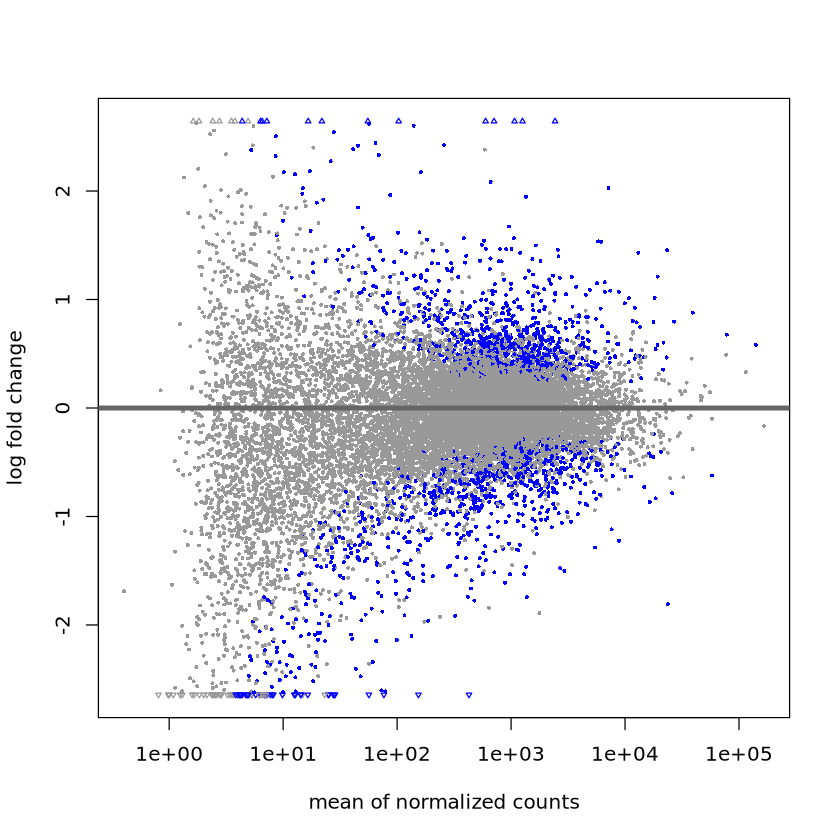

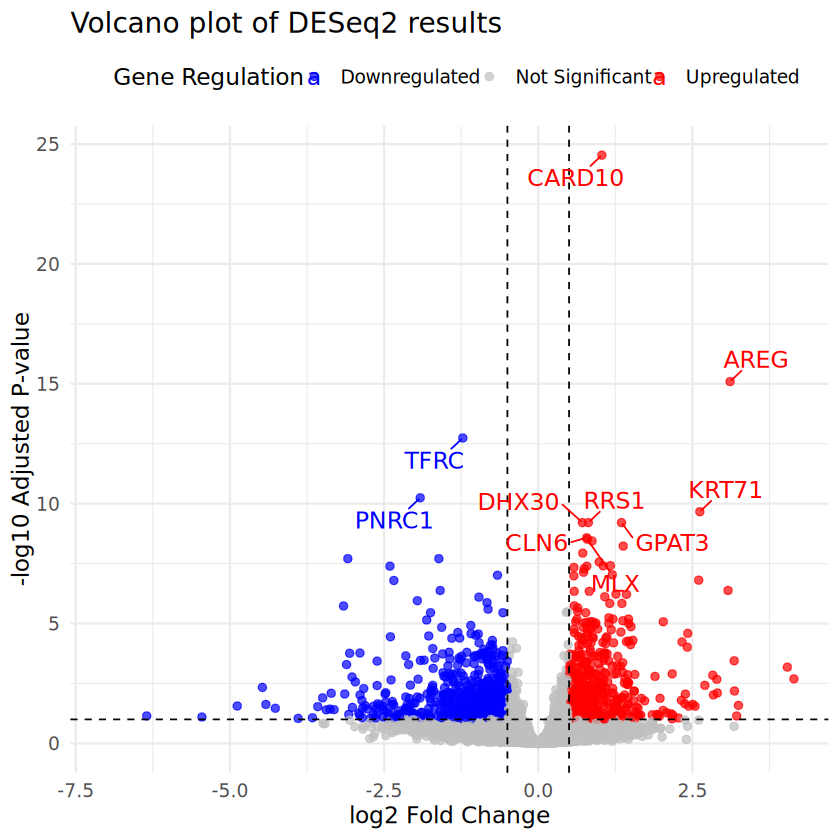

In [73]:
plotMA(res)

res_df <- as.data.frame(res)


# Добавляем -log10(p-value)
res_df$logP <- -log10(res_df$padj)

# Определяем статус гена по порогам
res_df$Significance <- "Not Significant"
res_df$Significance[res_df$padj < 0.1 & res_df$log2FoldChange > 0.5] <- "Upregulated"
res_df$Significance[res_df$padj < 0.1 & res_df$log2FoldChange < -0.5] <- "Downregulated"

# Отбираем топ-10 по значимости
ens2symb <- rowData(ddsTxi)
res_df$gene_symbol <- ens2symb$Symbol[match(rownames(res_df), rownames(ens2symb))]
top_genes <- res_df[order(res_df$padj, na.last = NA), ][1:10, ]
# top_genes <- rownames(res_df)[order(res_df$padj, na.last = NA)][1:10]

p <- ggplot(res_df, aes(x = log2FoldChange, y = logP, color = Significance)) +
  geom_point(alpha = 0.7, size = 2) +  # Точки
  scale_color_manual(values = c("Upregulated" = "red", 
                                "Downregulated" = "blue", 
                                "Not Significant" = "gray")) +
  geom_hline(yintercept = -log10(0.1), linetype = "dashed", color = "black") +  # Линия p-value
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "black") +  # Линии logFC
  geom_text_repel(data = top_genes, 
                  aes(label = gene_symbol), 
                  size = 5, box.padding = 0.5, max.overlaps = 10) +  # Подписи топ-10
  labs(title = "Volcano plot of DESeq2 results",
       x = "log2 Fold Change",
       y = "-log10 Adjusted P-value",
       color = "Gene Regulation") +
  theme_minimal(base_size = 14) +  # Минималистичный стиль
  theme(legend.position = "top")

# Выводим график
print(p)


## Сохранение результатов

### Сохранение TPM для функционального анализа

In [ ]:
tpm_ <- as.data.frame(tximport(
    samples_files,
    type="kallisto",
    tx2gene=t2g,
    ignoreAfterBar=TRUE,
    countsFromAbundance = "lengthScaledTPM"
)$counts)
rownames(tpm_) <- gsub("\\.\\d+$", "", rownames(tpm_))
tpm_ <- cbind(tpm_, genesMetaData)
head(tpm_)

Note: importing `abundance.h5` is typically faster than `abundance.tsv`



reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


summarizing abundance

summarizing counts

summarizing length



,male_1,male_2,male_3,male_4,male_5,male_6,female_1,female_2,female_3,female_4,female_5,female_6,Symbol,Entrez,Genetype
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ENSG00000000003,653.531374,605.0111,586.019326,592.718112,767.13105,539.472613,1125.90796,752.04578,698.960466,758.4342,564.20550,910.35474,TSPAN6,7105,protein-coding
ENSG00000000005,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.0000,0.00000,0.00000,TNMD,64102,protein-coding
ENSG00000000419,1094.437839,930.9325,839.435295,857.620657,1098.72698,863.947699,2820.45146,1237.78105,1165.235773,1172.1797,1186.31711,1542.79041,DPM1,8813,protein-coding
ENSG00000000457,145.548573,145.3309,205.363400,183.169846,131.37884,133.312800,186.11170,166.23093,146.586877,181.7000,249.24130,144.52004,SCYL3,57147,protein-coding
ENSG00000000460,437.833192,606.6337,310.360004,337.696659,686.43269,513.872872,418.32713,657.44352,555.973489,489.3252,370.45973,394.53733,FIRRM,55732,protein-coding
ENSG00000000938,7.683917,0.0000,8.546701,4.478162,14.25923,2.876387,12.29531,13.54213,5.720789,37.0802,53.83309,43.30251,FGR,2268,protein-coding


In [ ]:
write_csv(tpm_, file="data/TPM.csv")
# write_csv2(genesMetaData, file='data/genes_metadata.csv')

### Сохраняю результаты DeSeq2

Сохраню только значимо изменившиеся гены (p-value < 0.1)

In [ ]:
difexpr_resilts <- as.data.frame(subset(res, padj < 0.1))
rownames(difexpr_resilts) <- rowData(ddsTxi)[rownames(difexpr_resilts),]$Symbol
write.csv(difexpr_resilts, "data/difexpr_resilts.csv")

In [71]:
res_df <- left_join(res_df, rowData(ddsTxi))
head(res_df)

ERROR: Error in left_join(res_df, rowData(ddsTxi)): could not find function "left_join"
